# INF8775 – Analyse et conception d’algorithmes
# TP1 – Hiver 2025

Druet, Yann, 2198643

Provost-Cardin, Alexandre, 2210084

Note finale: 

<u>**Date limite de remise :**</u>  11 Février 23h59 (Groupe B2), 18 Février 23h59 (Groupe B1)

# Instructions

## Rédaction et remise du rapport

- Ce notebook constitue à la fois le sujet du TP, votre code et votre rapport. Il contient déjà du code pour faciliter vos mesures et l'affichage de vos résultats, ainsi qu'un squelette pour votre rapport.

- Complétez directement le notebook, vous êtes libres de créer des nouvelles cellules de code ou de texte. 

- Les questions et tâches à effectuer sont généralement indiquées par un TODO, mais lisez attentivement car nous pourrions avoir oublié d'en indiquer certaines.

- Des questions sont réutilisées d'un algorithme à l'autre (puisque l'on reproduit les expérimentations à des fins de comparaison). Veillez à suffisament développer les premières réponses afin de l'on comprenne bien votre raisonnement et pour montrer votre bonne compréhension. Vous pourrez être plus concis par la suite.

- <u>**IMPORTANT**</u> Remettez le fichier du notebook sur Moodle avec le nom `MATRICULE1_MATRICULE2.ipynb`

- Vous pouvez inclure du code trouvé sur Internet, mais vous devez en mentionner la source, sous peine d'être sanctionnés pour plagiat.

## Mise en situation

Ce travail pratique se répartit sur deux séances de laboratoire et porte sur l’analyse théorique et hybride des algorithmes. Dans les capsules vidéo de la semaine 3, trois approches d’analyse de l’implantation d’un algorithme sont décrites. Vous les mettrez en pratique pour des algorithmes de résolution d’un problème connu.

## Description du problème

On vous demande de résoudre le problème classique de trier une liste de nombres aléatoires.

La taille de la liste `SIZE` ainsi que la grandeur maximale des nombres permis `MAX_NUMBER` changeront d'un échantillon à l'autre. Il est **important** de considérer les deux variables dans vos analyses. Par contre, si vous prouvez qu'une des variables n'affecte pas la complexité d'un algorithme, il n'est pas nécessaire de compléter le reste de l'analyse pour celle-ci.

Porter une attention particulière à vos analyses, car c'est ce qui est le plus important dans ce travail. Assurez vous de respecter un certain formalisme, comme si vous rédigiez un rapport, et de bien expliquez tous vos résultats et graphiques. Une réponse sans explication ne rapportera pas tous les points.

## Algorithmes à implanter

On vous demande de résoudre ce problème de 5 façons différentes :

1. En utilisant un algorithme simple: `Insertion Sort` ;
2. En utilisant un algorithme diviser pour régner: `Quick Sort` en utilisant un pivot simple ;
3. En utilisant l'algorithme précédent avec une certaine heuristique pour sélectionner le pivot ;
4. En utilisant l'algorithme précédent avec un seuil de récursivité non élémentaire ;
5. En utilisant un algorithme non comparatif: `Count Sort`.

Pour l'algorithme 2, nous considérons simple de sélectionner la valeur au centre de la liste comme le pivot. Pour l'algo 3, vous pourriez utiliser la médiane ou la pseudo médiane de l'ensemble de la liste ou d'un sous-ensemble comme étant le pivot, mais il y a d'autre possibilités.

Pour l’algorithme 4, vous devrez déterminer un seuil de récursivité expérimentalement. Les exemplaires dont la taille est inférieure à ce seuil ne sont plus résolus récursivement mais plutôt directement avec l’algorithme 1.


## Jeu de données

La classe `Problem` existe pour simplifier l'interface des différentes fonctions utilitaires. Elle permet de générer des jeux de données avec la méthode `generate_sample` ci-dessous. Elle génère une liste de taille `SIZE` contenant des nombres entre 1 et `MAX_NUMBER`. Vous pouvez utilisez des listes aléatoires pour tester votre code.

In [2]:
import random
from collections.abc import Iterable

class Problem():
    def __init__(self, size: int, max_number: int, num_samples: int = 5) -> None:
        self.size=size
        self.max_number=max_number
        self.num_samples=num_samples
        self.samples = self.generate_dataset()
    
    def generate_sample(self) -> list[int]:
        """Returns a list of the given size containing numbers between 1 and the max_number"""
        return [random.randint(1, self.max_number) for _ in range(self.size)]
    
    def generate_dataset(self) -> Iterable[list[int]]:
        """Returns an iterator over as many samples as are described """
        return (self.generate_sample() for _ in range(self.num_samples))

# Implantations et expérimentations

Ces fonctions auxiliaires vous sont fournies pour vérifier l'exactitude des vos algorithmes, mesurer leur performance et afficher vos résultats.

Il est recommandé de prendre le temps de lire et comprendre le code.

Exécutez la cellule ci-dessous pour pouvoir utiliser les fonctions auxiliaires.

In [33]:
import matplotlib.pyplot as plt
import time
from collections.abc import Callable
from math import log10
from scipy.stats import linregress

class InvalidSolution(Exception):
    def __init__(self):
        super().__init__("Invalid solution, verify your code.")

class Measure():
    """A wrapper to contain information on taken measures"""
    def __init__(self, size: int, max_number: int, mean: int) -> None:
        self.size = size
        self.max_number = max_number
        self.mean = mean

def convert_list_to_dict(original: list[int]) -> dict[int:int]:
    """Converts a list into a dictionary of frequencies"""
    freq: dict[int:int] = dict()
    for iter in original:
        if iter not in freq.keys():
            freq[iter] = 0
        freq[iter] += 1
    return freq

def is_valid_solution(original: list[int], solution: list[int]) -> bool:
    """Validates both if the solution is sorted and if the list was not modified"""
    # Lists must be of equal length
    if len(solution) != len(original):
        return False
    
    # List must be in increasing order
    for i in range(1, len(solution)):
        if solution[i-1] > solution[i]:
            return False
    
    original_freq = convert_list_to_dict(original)
    solution_freq = convert_list_to_dict(solution)
    # Lists must have the same values
    for key in original_freq.keys():
        if key not in solution_freq.keys() or\
            solution_freq[key] != original_freq[key]:
            return False
    
    # Solution is valid
    return True

def make_problems(sizes: list[int], max_numbers: list[int], num_samples: int = 5) -> list[Problem]:
    """Creates problem instances using given sizes and max_numbers"""
    problems: list[Problem] = []
    for size in sizes:
        for max_number in max_numbers:
            problems.append(Problem(size,max_number,num_samples))
    return problems

def measure(procedure: Callable[[list[int]],list[int]], sample: list[int]) -> int:
    """Returns the time in milliseconds taken to run the procedure.

    Raises:
        InvalidSolution: If the procedure returns an invalid solution, raises an exception.
    """
    start: int = time.time() * 1000
    solution: list[int] = procedure(sample)
    end: int = time.time() * 1000
    if not is_valid_solution(sample, solution):
        raise InvalidSolution()
    return round(end - start)

def measure_mean(procedure: Callable[[list[int]],list[int]], prob: Problem) -> Measure:
    """Generates multiple samples with the specified parameters and returns the mean time in milliseconds

    Raises:
        InvalidSolution: If one of the samples results in an invalid solution.
    """
    mean_time = sum(
        [measure(procedure,sample) for sample in prob.samples]
    ) / prob.num_samples
    return Measure(prob.size, prob.max_number, mean_time)

def measure_range(procedure: Callable[[list[int]],list[int]], problems: list[Problem]) -> list[Measure]:
    """Measures the mean time taken in milliseconds for each size in the given list.
    Uses a fixed max_number to measure the effect of size on its own.

    Raises:
        InvalidSolution: If one of the samples results in an invalid solution.
    
    Returns:
        A list of Measure instances containing the specifications
        of the problem as well as the mean time.
    """
    return [
        measure_mean(procedure, prob)
        for prob in problems
    ]

def test_threshold(
    procedure: Callable[[list[int],int],list[int]],
    thresholds: list[int], problem: Problem
) -> dict[int,int]:
    """Tests the different thresholds on the same problem instance."""
    threshold_measures = dict()
    for threshold in thresholds:
        threshold_measures[threshold] = 0
        for sample in problem.generate_dataset():
            start = time.time() * 1000
            solution = procedure(sample,threshold)
            end = time.time() * 1000
            if not is_valid_solution(sample,solution):
                raise InvalidSolution()
            threshold_measures[threshold] += end - start
        threshold_measures[threshold] /= problem.num_samples
    return threshold_measures

def estimate_threshold(
    first_data: dict[int,int],
    second_data: dict[int,int],
    first_label: str,
    second_label: str
):
    plt.plot(list(first_data.keys()),list(first_data.values()),label=first_label)
    plt.plot(list(second_data.keys()),list(second_data.values()),label=second_label)
    plt.xlabel('Taille')
    plt.ylabel('Temps (ms)')
    plt.title('Estimation du seuil')
    plt.show()

def display_threshold_measures(data: dict[int,int]):
    """Displays a graph of the time take to solve in regards to the chosen threshold"""
    x = list(data.keys())
    y = list(data.values())
    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel('Seuil')
    plt.ylabel('Temps (ms)')
    plt.title('Selection du seuil')
    plt.show()
     
def display_data_as_table(measures: list[Measure]):
    """Prints a table with the data in the given list of measures"""
    print("{: <12} {: <12} {: <12}".format("Taille", "Nombre maximal", "Temps moyen (ms)"))
    for measure in measures:
        print("{: <12} {: <12} {: <12}".format(measure.size, measure.max_number, measure.mean))

### The different tests are below, the names are in french to avoid confusion

def test_de_puissance(
    data: dict[int,int],
    x_label: str,
    y_label: str,
    title: str = "Test de puissance"
):
    """Takes the data and displays it into the corresponding test graph.
    It applies no transformations to the data.

    Args:
        data (dict[int,int]): A dictionnary mapping the x variable to the y variable
    """
    # Log both sets of values
    x = list(data.keys())
    y = list(data.values())
    
    # Perform the lin regression
    m, b, rvalue, _, _ = linregress(x, y)
    
    # Estimate the values of y based on the lin regression results
    predicted = [m * iter + b for iter in x]

    # Create the line equation
    line_eq = f"y = {m:.2f}x + {b:.2f}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, predicted, color="red", label=f'Regression linéaire R²={round(rvalue**2,6)}')
    
    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

def test_de_rapport(
    data: dict[int,int],
    x_label: str,
    y_label: str,
    title: str = "Test de rapport"
):
    """Takes the data and displays it into the corresponding test graph.
    It applies no transformations to the data.
ired positional aro transformations to the data.

    Args:
        data (dict[int,int]): A dictionnary mapping the x variable to the y variable
    """
    x = list(data.keys())
    y = list(data.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)

    predicted = [m * iter + b for iter in x]

    # Create the line equation
    line_eq = f"y = {m:.2E}x + {b:.2E}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, predicted, color="red", label=f'Regression linéaire R²={round(rvalue**2,6)}')

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

## Exemple : Bubble Sort

In [4]:
def bubble_sort(original: list[int]) -> list[int]:
    for i in range(len(original)):
        for j in range(0, len(original)-i-1):
            if original[j] > original[j+1]:
                original[j], original[j+1] = original[j+1], original[j]
    return original

# This test would allow to see the variation associated to the SIZE variable
measures = measure_range(bubble_sort, make_problems([1000,1500,2000],[4000]))
display_data_as_table(measures)

# This test would allow to see the variation associated to the MAX_NUMBER variable. Results show that there is no variation
measures = measure_range(bubble_sort, make_problems([2000],[2000,3000,4000]))
display_data_as_table(measures)

Taille       Nombre maximal Temps moyen (ms)
1000         4000         36.8        
1500         4000         85.2        
2000         4000         157.8       
Taille       Nombre maximal Temps moyen (ms)
2000         2000         157.6       
2000         3000         159.0       
2000         4000         157.4       


## Partie 1 : Algorithme simple (Insertion Sort) (5 pts)

In [5]:
### Implantation

<u>**Question 1.a):**</u> Implantez l'algorithme de tri insertion sort.

Utilisez la fonction `is_valid_solution` pour valider votre réponse sur quelques exemplaires aléatoires.

In [18]:
def insertion_sort(original: list[int]) -> list[int]:
    i = 1
    while i < len(original):
        j = i
        while j > 0 and original[j-1] > original[j]:
            temp = original[j]
            original[j] = original[j-1]
            original[j-1] = temp
            j = j - 1
        i = i + 1
    return original

<u>**Question 1.b):**</u> Quelle est la complexité asymptotique théorique de cet algorithme? Expliquez
Meilleur cas: O(n)
Pire cas: O(n^2)
Cas moyen: O(n^2)

Dans le meilleur cas, la liste est déjà triée. On doit parcourir tous les éléments une fois pour les comparer (n éléments).
Dans le pire cas, la liste est triée dans l'ordre inverse. Chaque élément doit être comparé et échangé avec chaque autre élément (n éléments * n éléments) donc n^2.
Dans le cas moyen, la liste est partiellement aléatoire. Chaque élément devra être comparé avec une partie quelconque des autres éléments. La complexité reste quadratique. Ex. (n éléments * n éléments/2)

### Mesures

Pour cet algorithme ainsi que les prochains, vous devez choisir les différentes tailles de liste que vous voulez tester. Choisissez des tailles qui ont des résultats intéressants, une taille de 5 qui se termine en une fraction de millisecondes n'est pas le meilleur résultat pour faire des comparaisons.

Pour faire des mesures, utilisez la fonction `measure_range`. Elle permet de faire des mesures sur une liste de problèmes. Vous pouvez facilement créer des problèmes en utilisant la fonction `make_problems`. Ne faites varier que la taille <u>**OU**</u> la grandeur maximale des nombres pour observer le comportement d'un des deux paramètres. Le code fournit s'occupera de générer des échantillons aléatoires, de calculer le temps moyen et de vous retourner une liste de mesures. Vous pouvez utilisez la fonction `range` de python pour obtenir une grande liste et avoir plusieurs points (faites attention au temps d'exécution).

Ces données peuvent ensuite être passées aux fonctions `test_de_...` en les mettant dans un `dict` python tel que `x:y`. Les tests ont de la documentation pour expliquer leur utilisation en plus de détails.

<u>**Question 1.c):**</u> Faites afficher vos mesures dans un tableau avec la fonction `display_data_as_table`.

In [ ]:
# TODO take measurements
problems = make_problems([1000,1500,2000, 2500, 3000, 3500, 4000, 4500, 5000]) #Tous nos algorithmes utlisent les même problèmes`
measures_insertion_sort = measure_range(insertion_sort, problems)


In [47]:
# TODO Display data as tables
display_data_as_table(measures_insertion_sort)


Taille       Nombre maximal Temps moyen (ms)
1000         4000         30.2        
1500         4000         68.0        
2000         4000         126.2       


### Analyse Hybride

#### Test de puissance

<u>**Question 2.a):**</u> Effectuez le test de puissance de votre algorithme.

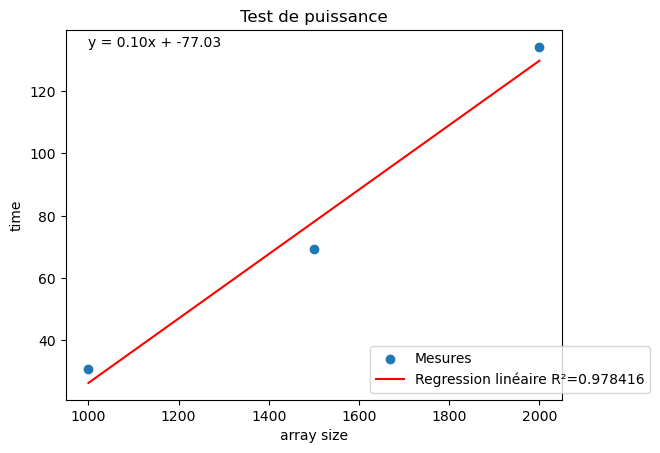

In [52]:
# TODO Test de puissance
mesure_insertion_sort_dict: dict[int: int] = {}
for i in measures_insertion_sort:
    mesure_insertion_sort_dict[i.size] = i.mean

test_de_puissance(mesure_insertion_sort_dict, "array size", "time")


<u>**Question 2.b):**</u> Analysez le graphe obtenu pour le test de puissance.

#### Test de rapport

<u>**Question 3.a):**</u> Effectuez le test de rapport de votre algorithme.

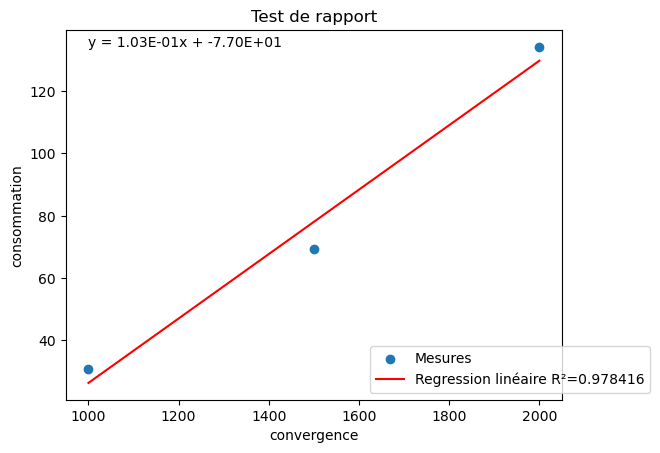

In [56]:
# TODO Test de rapport
test_de_rapport(mesure_insertion_sort_dict, "convergence", "consommation")

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test de rapport.

#### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes de votre algorithme.

In [ ]:
# TODO Test des constantes

<u>**Question 4.b):**</u> Analysez le graphe obtenu pour le test des constantes.

## Partie 2 : Algorithme diviser pour régner (Quick Sort) (5 pts)

### Implantation

<u>**Question 1.a):**</u> Implantez l'algorithme de tri quick sort avec un pivot simple.

Utilisez la fonction `is_valid_solution` pour valider votre réponse sur quelques exemplaires aléatoires.

In [51]:
def partition_array(array: list[int], left: int, right: int) -> int:
    pivot = array[right]
    i = left - 1

    for j in range(left, right):
        if array[j] <= pivot:
            i += 1
            array[i], array[j] = array[j], array[i]
    array[i + 1], array[right] = array[right], array[i + 1]

    return i + 1

def quick_sort_call(array: list[int], low: int, high: int): 
    if low < high:
        pivot = partition_array(array, low, high)
        quick_sort_call(array, low, pivot - 1)
        quick_sort_call(array, pivot + 1, high)
    
def quick_sort(original: list[int]) -> list[int]:
    low = 0
    high = len(original) - 1

    quick_sort_call(original, low, high)

    return original

<u>**Question 1.b):**</u> Quelle est la complexité asymptotique théorique de cet algorithme? Expliquez

### Mesures

<u>**Question 1.c):**</u> Faites afficher vos mesures dans un tableau avec la fonction `display_data_as_table`.

In [55]:
measures_quick_sort = measure_range(quick_sort, make_problems([1000,1500,2000, 2500, 3000, 3500, 4000, 4500, 5000],[4000]))

[2, 2, 2, 3, 4, 5, 5, 7, 7, 8, 8, 9, 9, 10, 45, 66]


In [54]:
display_data_as_table(measures_quick_sort)

Taille       Nombre maximal Temps moyen (ms)
1000         4000         1.6         
1500         4000         2.2         
2000         4000         3.0         
2500         4000         4.8         
3000         4000         5.2         
3500         4000         6.2         
4000         4000         7.4         
4500         4000         9.0         
5000         4000         8.8         


### Analyse Hybride

#### Test de puissance

<u>**Question 2.a):**</u> Effectuez le test de puissance de votre algorithme.

In [ ]:
# TODO Test de puissance

<u>**Question 2.b):**</u> Analysez le graphe obtenu pour le test de puissance.

#### Test de rapport

<u>**Question 3.a):**</u> Effectuez le test de rapport de votre algorithme.

In [ ]:
# TODO Test de rapport

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test de rapport.

#### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes de votre algorithme.

In [ ]:
# TODO Test des constantes

<u>**Question 4.b):**</u> Analysez le graphe obtenu pour le test des constantes.

## Partie 3 : Algorithme diviser pour régner amélioré (Quick Sort) (5 pts)

### Implantation

<u>**Question 1.a):**</u> Implantez l'algorithme de tri quick sort, avec une certaine heuristique pour sélectionner un pivot pertinent.

Utilisez la fonction `is_valid_solution` pour valider votre réponse sur quelques exemplaires aléatoires.

In [103]:
import statistics
def quick_sort_improved(original: list[int]) -> list[int]:
    low = 0
    high = len(original) - 1

    quick_sort_call_improved(original, low, high)
    return original

def medianOf3(array: list[int], left:int, right: int) -> int:
    mid = (left + right) // 2
    values = [array[left], array[right], array[mid]]
    median_value = statistics.median(values)

    median_index = mid
    if array[left] == median_value:
        median_index = left

    if array[right] == median_value:
        median_index = right 

    array[median_index], array[right] = array[right], array[median_index]

    return partition_array_improved(array, left, right)

def partition_array_improved(array: list[int], left: int, right: int) -> int:
    pivot = array[right]
    i = left - 1

    for j in range(left, right):
        if array[j] <= pivot:
            i += 1
            array[i], array[j] = array[j], array[i]
    array[i + 1], array[right] = array[right], array[i + 1]

    return i + 1


def quick_sort_call_improved(array: list[int], low: int, high: int): 
    if low < high: 
        pivot = medianOf3(array, low, high)
        quick_sort_call_improved(array, low, pivot - 1)
        quick_sort_call_improved(array, pivot + 1, high)

<u>**Question 1.b):**</u> Quelle est la complexité asymptotique théorique de cet algorithme? Expliquez

<u>**Question 1.c):**</u> Quelle est l'impact de l'ajout de votre heuristique? Expliquez

### Mesures

<u>**Question 1.d):**</u> Faites afficher vos mesures dans un tableau avec la fonction `display_data_as_table`.

In [110]:
# TODO take measurements
measures_quick_sort_improved = measure_range(quick_sort_improved, make_problems([1000,1500,2000, 2500, 3000, 3500, 4000, 4500, 5000],[4000]))

In [111]:
# TODO Display data as tables
display_data_as_table(measures_quick_sort_improved)

Taille       Nombre maximal Temps moyen (ms)
1000         4000         1.0         
1500         4000         2.0         
2000         4000         2.0         
2500         4000         3.0         
3000         4000         3.2         
3500         4000         4.0         
4000         4000         5.0         
4500         4000         5.8         
5000         4000         6.0         


### Analyse Hybride

#### Test de puissance

<u>**Question 2.a):**</u> Effectuez le test de puissance de votre algorithme.

In [ ]:
# TODO Test de puissance

<u>**Question 2.b):**</u> Analysez le graphe obtenu pour le test de puissance.

#### Test de rapport

<u>**Question 3.a):**</u> Effectuez le test de rapport de votre algorithme.

In [ ]:
# TODO Test de rapport

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test de rapport.

#### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes de votre algorithme.

In [ ]:
# TODO Test des constantes

<u>**Question 4.b):**</u> Analysez le graphe obtenu pour le test des constantes.

## Partie 4 : Algorithme diviser pour régner avec seuil arbitraire (Quick Sort) (5 pts)

### Implantation

<u>**Question 1.a):**</u> Quel serait un meilleur choix de seuil? Utilisez la fonction `estimate_threshold` pour avoir une idée où commencer. Analysez le graphe résultant et choisissez un seuil de départ.

On recommande de compiler des nouvelles données sur des tailles plus petites. Utilisez un `time_scale` plus grand pour avoir plus de détails (indiquez les unités dans le `y_label`). Une fois que vous avez une idée d'où se situe le point de croisement, vous pouvez refaire le test sur une sélection plus restreinte de tailles en augmentant `num_samples` pour avoir des résultats plus constants.

In [ ]:
# TODO Find a better starting point for the threshold

<u>**Question 1.b):**</u> Reprenez l'algorithme précédent et modifiez-le pour y ajouter un seuil de récursivité. En dessous de ce seuil, vous utiliserez l'algorithme `insertion_sort` écrit précédemment.

Utilisez la fonction `is_valid_solution` pour valider votre réponse sur quelques exemplaires aléatoires.

In [ ]:
def quick_sort_threshold(original: list[int], threshold: int = 1) -> list[int]:
    # TODO
    if len(array) < 10:
        insertion_sort(array)
    elif low < high: 
        pivot = medianOf3(array, low, high)
        quick_sort_call_improved(array, low, pivot - 1)
        quick_sort_call_improved(array, pivot + 1, high)
    return original

<u>**Question 1.c):**</u> À l'aide de ce que vous avez vu dans la section précédente, effectuez les mesures avec plusieurs seuils de récursivité pour déterminer le seuil le plus judicieux. Affichez les dans un graphique une fois que les mesures sont compilées. La fonction `test_threshold` vous sera utile pour faire ces tests. Choisissez bien vos seuils ainsi qu'une taille de liste permettant de bien observer la différence de performance.

In [ ]:
# TODO Test different threshold values

In [ ]:
# TODO Display a graph with the measurements

<u>**Question 1.d):**</u> Quel est le seuil de récursivité le plus judicieux? Sur quel critère l'avez vous sélectionné? Pourquoi des seuils inférieurs ou supérieurs donnent-ils de moins bonnes performances?

Changez le seuil par défaut de votre fonction au meilleur choix. Ceci vous permettra d'utiliser les fonctions utilitaires sans passer le seuil comme argument.

<u>**Question 1.e):**</u> Quelle est la complexité asymptotique théorique de cet algorithme? Expliquez

### Mesures

<u>**Question 1.f):**</u> Faites afficher vos mesures dans un tableau avec la fonction `display_data_as_table`.

In [ ]:
# TODO take measurements

In [ ]:
# TODO Display data as tables

### Analyse Hybride

#### Test de puissance

<u>**Question 2.a):**</u> Effectuez le test de puissance de votre algorithme.

In [ ]:
# TODO Test de puissance

<u>**Question 2.b):**</u> Analysez le graphe obtenu pour le test de puissance.

#### Test de rapport

<u>**Question 3.a):**</u> Effectuez le test de rapport de votre algorithme.

In [ ]:
# TODO Test de rapport

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test de rapport.

#### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes de votre algorithme.

In [ ]:
# TODO Test des constantes

<u>**Question 4.b):**</u> Analysez le graphe obtenu pour le test des constantes.

<u>**Question 5):**</u> Commentez l'impact du seuil de récursivité. Que représente-t-il pour l'algorithme diviser pour régner et l'algorithme naïf ?

## Partie 5 : Algorithme non comparatif (Count Sort) (5 pts)

### Implantation

<u>**Question 1.a):**</u> Implantez l'algorithme de tri count sort. Cet algorithme ne fait pas de comparaison entre les différents éléments de la liste.

Utilisez la fonction `is_valid_solution` pour valider votre réponse sur quelques exemplaires aléatoires.

In [14]:
def count_sort(original: list[int]) -> list[int]:
    # TODO
    return original

<u>**Question 1.b):**</u> Quelle est la complexité asymptotique théorique de cet algorithme? Expliquez

<u>**Question 1.c):**</u> Quel sera l'effet de cette complexité comparativement aux algorithmes précédents.

### Mesures

<u>**Question 1.d):**</u> Faites afficher vos mesures dans un tableau avec la fonction `display_data_as_table`. Étant donné les particularités de cet algorithme, il serait plus pertinent de tester des problèmes où max number ≤ size.

In [ ]:
# TODO take measurements

In [ ]:
# TODO Display data as tables

### Analyse Hybride

#### Test de puissance

<u>**Question 2.a):**</u> Effectuez le test de puissance de votre algorithme.

In [ ]:
# TODO Test de puissance

<u>**Question 2.b):**</u> Analysez le graphe obtenu pour le test de puissance.

#### Test de rapport

<u>**Question 3.a):**</u> Effectuez le test de rapport de votre algorithme.

In [ ]:
# TODO Test de rapport

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test de rapport.

#### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes de votre algorithme.

In [ ]:
# TODO Test des constantes

<u>**Question 4.b):**</u> Analysez le graphe obtenu pour le test des constantes.

# Conclusion (3 pts)

Résumez *brièvement* vos découvertes et analyses, et indiquez dans quelles circonstances vous utiliserez chacun de ces algorithmes.

 ## Autres critères (2 pts)
 Qualité du code / 1 pt

Présentation générale / 1 pt

- Concision
- Qualité du français

Pénalité retard
- -1 pt / journée de retard, arrondi vers le haut. Les TPs ne sont plus acceptés après 3 jours.